In [1]:
import argparse
import datetime
import glob
import math
import numpy as np
import os
import pandas as pd
import rasterio
import seaborn as sns
import statsmodels.api as sm
import time
import xarray as xr

import sys
sys.path.append('../')

from functools import reduce
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

from utils import power_curve
from utils import windpower_simulation_era5
from utils import windpower_simulation_merra2


from dask.diagnostics import ProgressBar
ProgressBar().register()

from paths_usa import *
ryberg_path = "/data/users/kgruber/other-data"

In [2]:
wind = xr.open_mfdataset(mer_path + "/eff_ws/merra2_wind_USA_*.nc", chunks = {'time': 38})
alpha = xr.open_mfdataset(mer_path + "/eff_ws/merra2_alpha_USA_*.nc")

# without GWA
outfile = results_path + '/windpower_stat_MERRA2.nc'
turbine_data_mer = pd.read_csv(usa_path + '/turbine_data_mer.csv', parse_dates=['commissioning'])

here only commissioning changed - years instead of dates

In [3]:
t1 = datetime.datetime.now()

In [4]:
num_loc = 1906
hubheight = turbine_data_mer.height.values[:num_loc]
capacity = turbine_data_mer.capacity.values[:num_loc]
specific_pow = turbine_data_mer.sp.values[:num_loc]
lons = turbine_data_mer.lon.values[:num_loc]
lats = turbine_data_mer.lat.values[:num_loc]
commissioning = pd.to_datetime(turbine_data_mer.commissioning.values).year.values[:num_loc]

In [5]:
type(turbine_data_mer.commissioning.values[0])==np.datetime64

True

In [6]:
type(commissioning[0])==np.int64

False

In [7]:
# interpolate wind to locations of turbines
wind50i = wind.wh50.interp(coords={"lon":xr.DataArray(lons,dims='location'),
                                   "lat":xr.DataArray(lats,dims='location')},method="nearest").compute()

alphai = alpha.alpha.interp(coords={"lon":xr.DataArray(lons,dims='location'),
                                    "lat":xr.DataArray(lats,dims='location')},method="nearest").compute()
# calculate wind at hubheight using alpha
windhh = (wind50i * (hubheight/50)**alphai).compute()

[########################################] | 100% Completed | 42.1s
[########################################] | 100% Completed | 43.7s


In [8]:
windhhg = windhh.where(windhh<=25,0)

# Ryberg power curve model
RybCoeff = pd.read_csv(ryberg_path+"/ryberg_coeff.csv")
A = xr.DataArray(RybCoeff.A, dims = 'CF')
B = xr.DataArray(RybCoeff.B, dims = 'CF')
wp1 = power_curve(windhhg,A,B,specific_pow,len(windhhg.location))

# multiply with installed capacity
wp2 = capacity*wp1/100

-> use pandas date range

### this part is new

In [9]:
timespans = [np.array(pd.date_range(pd.to_datetime(str(y)+'-01-01 00:00:00'),pd.to_datetime(str(y)+'-12-31 23:00:00'),freq='H')) for y in commissioning]
locs = np.concatenate([np.array([wp2.location.values[i]]*len(timespans[i])) for i in range(len(timespans))])
timespans = np.concatenate(timespans)

In [10]:
# make sure there are no indices before or after wind time series
locs_s = np.array(locs)[(timespans>=wp2.time[0].values)&(timespans<=wp2.time[-1].values)]
timespans_s = np.array(timespans)[(timespans>=wp2.time[0].values)&(timespans<=wp2.time[-1].values)]

In [11]:
timespans_s.min()

numpy.datetime64('2000-12-01T00:00:00.000000000')

In [12]:
timespans_s.max()

numpy.datetime64('2018-12-31T23:00:00.000000000')

In [13]:
wind_com_years = wp2.loc[{'location':xr.DataArray(locs_s,dims='cy'),
                          'time':xr.DataArray(timespans_s,dims='cy')}]

In [14]:
fact = np.concatenate([np.arange(1,x+1)/x for x in np.unique(locs_s, return_counts=True)[1]])

In [15]:
# insert the gradually increasing capacities
wp2.loc[{'location':xr.DataArray(locs_s,dims='cy'),
         'time':xr.DataArray(timespans_s,dims='cy')}] = wind_com_years * fact

In [16]:
# create commissioning dates and set those before beginning of time series to beginning of time series
comdate = np.array([np.datetime64(str(y)+'-01-01 00:00:00') for y in commissioning])
comdate[comdate<wp2.time.values[0]] = wp2.time.values[0]

this is the end of the new part - only the commissioning changed to comdate in the next line

In [17]:
# make wind power generation increase to full capacity in commissioning year
wp3 =  wp2.where(wp2.time >= xr.DataArray(comdate,coords={'location':range(len(commissioning))},dims='location'), 0).compute()

In [18]:
t2 = datetime.datetime.now()

In [19]:
t2 -t1

datetime.timedelta(seconds=154, microseconds=225251)

In [20]:
154/60

2.566666666666667

/home/kgruber/.conda/envs/py37/lib/python3.7/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


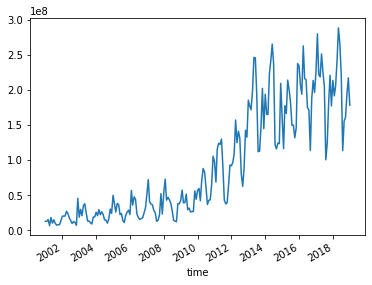

In [18]:
wp3.resample(time='M').sum().plot(hue='location')